<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
8.48MB [00:00, 32.2MB/s]


In [3]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


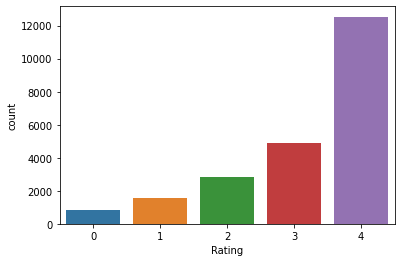

In [5]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
sns.countplot(x='Rating', data=df_reviews)
plt.show()

El dataset se encuentra fuertemente desbalanceado

In [7]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values

In [8]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
text_sequences.shape

(22641,)

In [9]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [10]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens) 

In [19]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [69]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [72]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [ ]:
len_seq = [len(s) for s in sequences]
plt.hist(len_seq,bins=20)

In [73]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [74]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [136]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la máxima
# cantidad de palabras definidas para el vocabulario (vocab_size)
from sklearn.preprocessing import OneHotEncoder
y_encoder = OneHotEncoder(sparse= False)
y = y_encoder.fit_transform(df_reviews['Rating'].values.reshape(-1,1))

In [138]:
print(y.shape)

(22641, 5)


In [137]:
y[0:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [169]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y )

In [170]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # multi-class classification

### 2 - Entrenar el modelo con Embeddings + LSTM

#### Clasificación multi-clase utilizando fasttext embeddings

In [208]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional

In [172]:
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [173]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [174]:
model_fasttext = FasttextEmbeddings()

In [175]:
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

In [182]:
!pip install tensorflow-addons

import tensorflow_addons as tfa 
f1_score = tfa.metrics.F1Score(out_shape,'macro')

In [185]:
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model1.add(LSTM(units=64, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=64))
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=out_shape, activation='softmax'))

model1.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_score])

model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 115, 300)          600000    
_________________________________________________________________
lstm_32 (LSTM)               (None, 115, 64)           93440     
_________________________________________________________________
dropout_31 (Dropout)         (None, 115, 64)           0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)               

In [186]:
hist1 = model1.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 30s 59ms/step - loss: 1.2295 - accuracy: 0.5552 - f1_score: 0.2665 - val_loss: 1.2286 - val_accuracy: 0.5402 - val_f1_score: 0.1403
Epoch 2/50
453/453 [==============================] - 26s 56ms/step - loss: 1.1853 - accuracy: 0.5573 - f1_score: 0.1431 - val_loss: 1.1867 - val_accuracy: 0.5402 - val_f1_score: 0.1403
Epoch 3/50
453/453 [==============================] - 26s 57ms/step - loss: 1.1548 - accuracy: 0.5593 - f1_score: 0.1590 - val_loss: 1.1882 - val_accuracy: 0.5363 - val_f1_score: 0.1894
Epoch 4/50
453/453 [==============================] - 26s 56ms/step - loss: 1.1296 - accuracy: 0.5641 - f1_score: 0.1860 - val_loss: 1.1249 - val_accuracy: 0.5484 - val_f1_score: 0.1924
Epoch 5/50
453/453 [==============================] - 26s 57ms/step - loss: 1.1099 - accuracy: 0.5677 - f1_score: 0.1973 - val_loss: 1.1187 - val_accuracy: 0.5490 - val_f1_score: 0.1882
Epoch 6/50
453/453 [==============================] - 26s 58ms/step - 

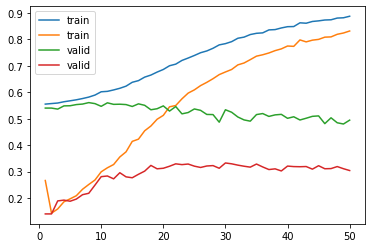

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist1.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist1.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist1.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist1.history['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=hist1.history['val_f1_score'], label='valid')
plt.show()

In [188]:
model1.evaluate(X_test, y_test)

142/142 [==============================] - 3s 21ms/step - loss: 2.5641 - accuracy: 0.5054 - f1_score: 0.3090


[2.564133882522583, 0.5054095983505249, 0.3089558482170105]

Observamos que el modelo tiene la complejidad suficiente para el problema, pero tenemos un gran overfitting. Se concluye que hacen falta mas reviews para obtener mejores resultados, espcialmente para balancear el dataset.

#### Clasificación multi-clase utilizando embeddings propios

In [189]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_score])

model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 115, 50)           100050    
_________________________________________________________________
lstm_34 (LSTM)               (None, 115, 64)           29440     
_________________________________________________________________
dropout_33 (Dropout)         (None, 115, 64)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)               

In [190]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 30s 59ms/step - loss: 1.0202 - accuracy: 0.5987 - f1_score: 0.2818 - val_loss: 0.9314 - val_accuracy: 0.6034 - val_f1_score: 0.2799
Epoch 2/50
453/453 [==============================] - 26s 58ms/step - loss: 0.8749 - accuracy: 0.6341 - f1_score: 0.3430 - val_loss: 0.9279 - val_accuracy: 0.6020 - val_f1_score: 0.3390
Epoch 3/50
453/453 [==============================] - 27s 59ms/step - loss: 0.8215 - accuracy: 0.6527 - f1_score: 0.4043 - val_loss: 0.9097 - val_accuracy: 0.6092 - val_f1_score: 0.3701
Epoch 4/50
453/453 [==============================] - 27s 59ms/step - loss: 0.7674 - accuracy: 0.6704 - f1_score: 0.4517 - val_loss: 0.9251 - val_accuracy: 0.6147 - val_f1_score: 0.3531
Epoch 5/50
453/453 [==============================] - 27s 59ms/step - loss: 0.7334 - accuracy: 0.6903 - f1_score: 0.4913 - val_loss: 0.9448 - val_accuracy: 0.6183 - val_f1_score: 0.4175
Epoch 6/50
453/453 [==============================] - 27s 59ms/step - 

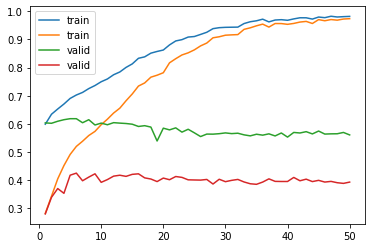

In [191]:
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=hist2.history['val_f1_score'], label='valid')
plt.show()

In [192]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 3s 21ms/step - loss: 3.2884 - accuracy: 0.5646 - f1_score: 0.3818


[3.288365125656128, 0.5645837783813477, 0.38182032108306885]

En este caso obtuvimos mejores métricas pero aún se evidencia la presencia de overfitting

####  Bidirectional LSTM

In [216]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size+1, output_dim=20, input_length=in_shape))
model3.add(LSTM(32))
model3.add(Dropout(0.2))
model3.add(Dense(units=out_shape, activation='softmax'))

model3.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_score])

model3.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 115, 20)           40020     
_________________________________________________________________
lstm_50 (LSTM)               (None, 32)                6784      
_________________________________________________________________
dropout_49 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 165       
Total params: 46,969
Trainable params: 46,969
Non-trainable params: 0
_________________________________________________________________


In [217]:
hist3 = model3.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 13s 24ms/step - loss: 1.0716 - accuracy: 0.5794 - f1_score: 0.2536 - val_loss: 0.9525 - val_accuracy: 0.5959 - val_f1_score: 0.2626
Epoch 2/50
453/453 [==============================] - 10s 23ms/step - loss: 0.8881 - accuracy: 0.6265 - f1_score: 0.3090 - val_loss: 0.9423 - val_accuracy: 0.6028 - val_f1_score: 0.2795
Epoch 3/50
453/453 [==============================] - 10s 23ms/step - loss: 0.8436 - accuracy: 0.6452 - f1_score: 0.3585 - val_loss: 0.9442 - val_accuracy: 0.6028 - val_f1_score: 0.3343
Epoch 4/50
453/453 [==============================] - 10s 23ms/step - loss: 0.8060 - accuracy: 0.6577 - f1_score: 0.3979 - val_loss: 0.8917 - val_accuracy: 0.6105 - val_f1_score: 0.3667
Epoch 5/50
453/453 [==============================] - 10s 23ms/step - loss: 0.7749 - accuracy: 0.6672 - f1_score: 0.4324 - val_loss: 0.9405 - val_accuracy: 0.6172 - val_f1_score: 0.3676
Epoch 6/50
453/453 [==============================] - 10s 23ms/step - 